In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

art = pd.read_csv("data/articles_processed.csv")            # 상품 메타데이터
cust = pd.read_csv("data/customer_processed.csv")           # 고객 메타데이터
total_revenue = pd.read_csv("data/total_revenue.csv")       # 매출 데이터

# 안전하게 날짜형 변환
total_revenue["t_dat"] = pd.to_datetime(total_revenue["t_dat"])

In [2]:
art.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_info',
       'product_group_name', 'graphical_appearance_info',
       'perceived_colour_master_info', 'department_info', 'index_info',
       'index_group_info', 'section_info', 'garment_group_info'],
      dtype='str')

In [3]:
cust.columns

Index(['customer_id', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'age_group'],
      dtype='str')

In [4]:
total_revenue.columns

Index(['t_dat', 'customer_id', 'article_id', 'revenue', 'sales_channel_id',
       'month', 'year_month', 'month_day', 'total_revenue', 'revenue_group'],
      dtype='str')

In [5]:
total_revenue.info()

<class 'pandas.DataFrame'>
RangeIndex: 1037772 entries, 0 to 1037771
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   t_dat             1037772 non-null  datetime64[us]
 1   customer_id       1037772 non-null  str           
 2   article_id        1037772 non-null  int64         
 3   revenue           1037772 non-null  float64       
 4   sales_channel_id  1037772 non-null  int64         
 5   month             1037772 non-null  int64         
 6   year_month        1037772 non-null  str           
 7   month_day         1037772 non-null  str           
 8   total_revenue     1037772 non-null  float64       
 9   revenue_group     1037772 non-null  str           
dtypes: datetime64[us](1), float64(2), int64(3), str(4)
memory usage: 79.2 MB


In [6]:
# ---------------------------------------------------------------------
# 분석용 total_revenue × customer
# 거래(매출, 날짜, 채널) + 고객 속성
# 상품은 단순 구매 대상이고 “무엇을 샀는지”는 부차적
# 어떤 고객이 매출을 만들고, 멤버십/뉴스레터는 효과가 있고 재구매 구조는 어떤한가?
# ---------------------------------------------------------------------

analysis_cust = (
    total_revenue
    .merge(cust, on="customer_id", how="inner")
)
analysis_cust.columns

Index(['t_dat', 'customer_id', 'article_id', 'revenue', 'sales_channel_id',
       'month', 'year_month', 'month_day', 'total_revenue', 'revenue_group',
       'FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age',
       'age_group'],
      dtype='str')

In [7]:
# ---------------------------------------------------------------------
# 분석용 total_revenue × articles
# "무엇이 팔렸는가"에 집중한 데이터
# 거래(매출, 날짜, 채널) + 상품 속성
# 고객 속성이 들어가 있지 않기 떄문에 고객 차이는 관심 대상 아님
# 매출을 구성하는 상품 구조 파악 (product_type / garment_group / section / 색상군 / 외형) 
# 월별 × 상품군 판매량으로 특정 시즌에 강한 상품 / 약한 상품 파악
# 매출 상위 몇 개 상품군에 집중되어 있는지
# ---------------------------------------------------------------------

analysis_art = (
    total_revenue
    .merge(art, on="article_id", how="inner")
)
analysis_art.shape

(1037772, 21)

In [8]:
# ---------------------------------------------------------------------
# 전체 조인 (total_revenue × customer × articles)
# 볼수 있는 데이터
# 고객군별 선호 상품 연령대 × garment_group, 고객의 취향 파악 가능
# 이를 통해 타겟 전략 점검 가능 (특정 고객군이 특정 라인에 몰려 있는지)
# 가입한 사람이 아닌 소비한 고객을 골라야 하기 때문에 inner 사용
# ---------------------------------------------------------------------

analysis_master = (
    total_revenue
    .merge(cust, on="customer_id", how="inner")
    .merge(art, on="article_id", how="inner")
)
analysis_master.shape

(804149, 27)

### 누적구매율과 비중으로 확인하는 고객 분류

In [9]:
# 필요컬럼 호출
tx = analysis_cust[["customer_id", "t_dat", "year_month"]].copy()

# 날짜형 변경
tx["t_dat"] = pd.to_datetime(tx["t_dat"])


# 고객별로 날짜 순 정렬
tx = tx.sort_values(["customer_id", "t_dat"])

# 고객별 누적 구매 횟수
tx["transaction_cnt"] = (
    tx
    .groupby("customer_id")
    .cumcount() + 1
)

tx.head()

,customer_id,t_dat,year_month,transaction_cnt
77235,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2019-05-25,2019-05,1
677888,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2019-09-28,2019-09,2
696491,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2019-05-07,2019-05,1
600809,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2019-05-22,2019-05,2
522736,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2019-06-18,2019-06,3


In [10]:
tx.info()

<class 'pandas.DataFrame'>
Index: 804149 entries, 77235 to 4300
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   customer_id      804149 non-null  str           
 1   t_dat            804149 non-null  datetime64[us]
 2   year_month       804149 non-null  str           
 3   transaction_cnt  804149 non-null  int64         
dtypes: datetime64[us](1), int64(1), str(2)
memory usage: 30.7 MB


In [11]:
# 고객-월 단위로 "그 달까지 누적 구매 횟수" 만들기
# 한 달에 여러 번 사도, 그 달의 누적 상태는 max가 대표
monthly_customer = (
    tx
    .groupby(["year_month", "customer_id"], as_index=False)
    .agg(
        transaction_cnt=("transaction_cnt", "max")
    )
)

monthly_customer.info()

<class 'pandas.DataFrame'>
RangeIndex: 612550 entries, 0 to 612549
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   year_month       612550 non-null  str  
 1   customer_id      612550 non-null  str  
 2   transaction_cnt  612550 non-null  int64
dtypes: int64(1), str(2)
memory usage: 14.0 MB


- tx: 1행 = 1번의 구매(거래): 804149
    - 같은 고객이 같은 달에 여러 번 구매하면 여려 행이 존재

- monthly_customer: 612550
    - 같은 고객이 같은 달에 여러 번 구매했더라도 그 달의 ‘누적 구매 횟수 최종값’만 남긴다.
    - 같은 고객의 여러 거래를 1행으로 압축

때문에 행 감소 발생은 당연한 수치다.

In [12]:
# 누적 구매횟수 기준으로 고객 유형 분류

# 신규고객 배정
monthly_customer["customer_type"] = "New"

# 재구매 고객 분류
monthly_customer.loc[
    monthly_customer["transaction_cnt"] >= 2,
    "customer_type"
] = "Repeat"

# 충성 고객 분류
monthly_customer.loc[
    monthly_customer["transaction_cnt"] >= 4,
    "customer_type"
] = "Loyal"

# 분류고객 합산 결과
monthly_customer["customer_type"].value_counts()

customer_type
New       282165
Repeat    210846
Loyal     119539
Name: count, dtype: int64

In [13]:
# 월별로 고객 유형별 "고객 수" 세기
monthly_count = (
    monthly_customer
    .groupby(["year_month", "customer_type"], as_index=False)
    .agg(
        customer_cnt=("customer_id", "nunique") # 거래행이 아닌 고객으로 카운트
    )
)

# 월별로 고객 유형별 "고객 수" 비중
# 고객유형별 고객 수 / 해당 월 전체 고객 수

monthly_count["ratio"] = (
    monthly_count["customer_cnt"]
    / monthly_count
        .groupby("year_month")["customer_cnt"]
        .transform("sum")
)

monthly_count.isna().sum()

year_month       0
customer_type    0
customer_cnt     0
ratio            0
dtype: int64

In [14]:
# 누적구매율 pivot 형태로 변환
pivot_cnt = (
    monthly_count
    .pivot(
        index="year_month", # x
        columns="customer_type", # (New / Repeat / Loyal) y
        values="customer_cnt" # y
    )
    .fillna(0)
    .sort_index()
)

# 누적구매 비중 pivot 형태로 변환
pivot_ratio = (
    monthly_count
    .pivot(
        index="year_month", 
        columns="customer_type", 
        values="ratio"
    )
    .fillna(0)
    .sort_index()
)

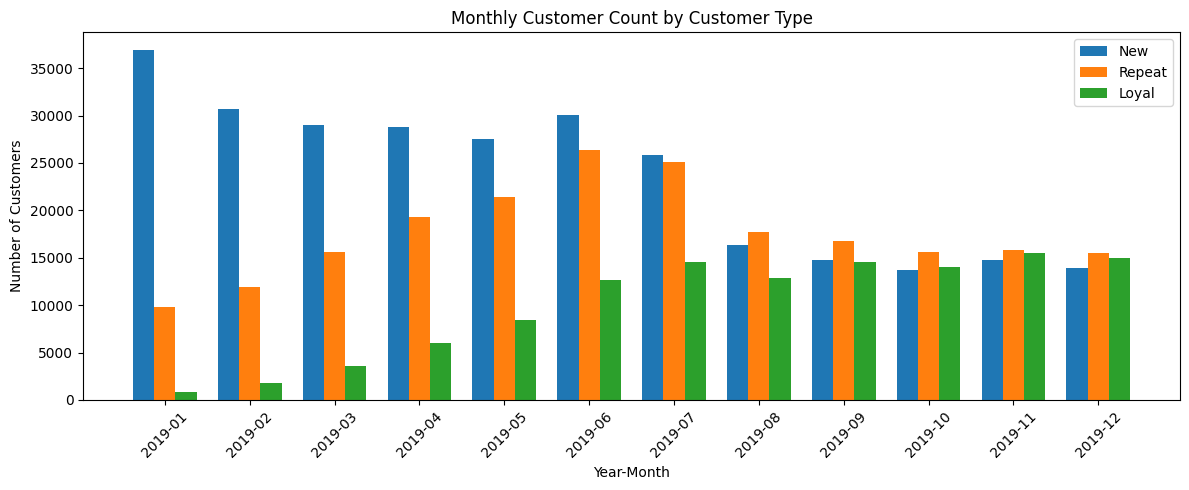

customer_type,Loyal,New,Repeat
year_month,,,
2019-01,849,36928,9837
2019-02,1764,30663,11873
2019-03,3543,28977,15583
2019-04,6036,28767,19330
2019-05,8446,27546,21361
2019-06,12684,30095,26354
2019-07,14538,25846,25138
2019-08,12827,16308,17666
2019-09,14497,14751,16747


In [15]:
# 고객유형별 막대그래프 (나란히 배치)
x = np.arange(len(pivot_cnt.index))   # 월 위치
width = 0.25                          # 막대 너비

plt.figure(figsize=(12, 5))

# 왼쪽: New 고객
plt.bar(
    x - width,
    pivot_cnt["New"],
    width=width,
    label="New"
)

# 가운데: Repeat 고객
plt.bar(
    x,
    pivot_cnt["Repeat"],
    width=width,
    label="Repeat"
)

# 오른쪽: Loyal 고객
plt.bar(
    x + width,
    pivot_cnt["Loyal"],
    width=width,
    label="Loyal"
)

plt.title("Monthly Customer Count by Customer Type")
plt.xlabel("Year-Month")
plt.ylabel("Number of Customers")
plt.xticks(x, pivot_cnt.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

pivot_cnt

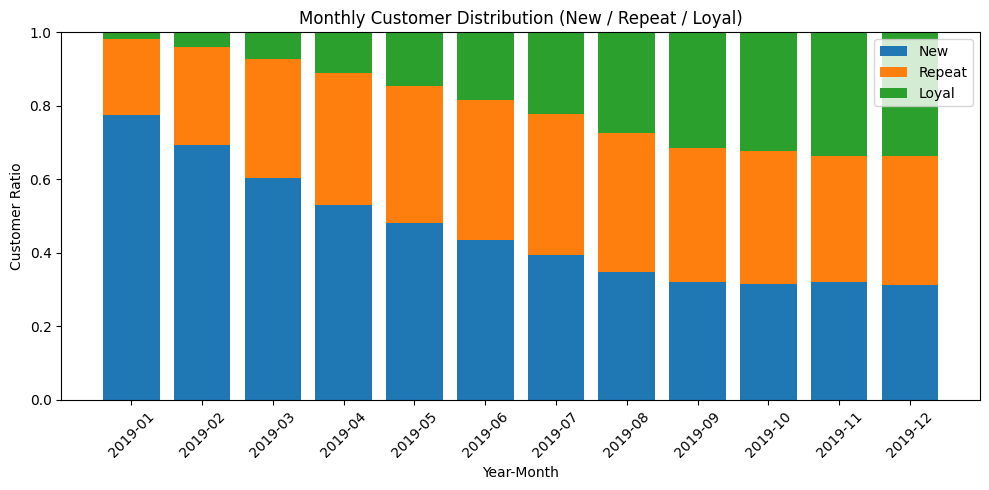

customer_type,Loyal,New,Repeat
year_month,,,
2019-01,0.017831,0.775570,0.206599
2019-02,0.039819,0.692167,0.268014
2019-03,0.073654,0.602395,0.323951
2019-04,0.111503,0.531413,0.357083
2019-05,0.147263,0.480289,0.372448
2019-06,0.183472,0.435320,0.381207
2019-07,0.221880,0.394463,0.383657
2019-08,0.274075,0.348454,0.377471
2019-09,0.315186,0.320709,0.364105


In [16]:
plt.figure(figsize=(10, 5))

# New 고객
plt.bar(
    pivot_ratio.index,
    pivot_ratio["New"],
    label="New"
)

# Repeat 고객
plt.bar(
    pivot_ratio.index,
    pivot_ratio["Repeat"],
    bottom=pivot_ratio["New"],
    label="Repeat"
)

# Loyal 고객
plt.bar(
    pivot_ratio.index,
    pivot_ratio["Loyal"],
    bottom=pivot_ratio["New"] + pivot_ratio["Repeat"],
    label="Loyal"
)

plt.title("Monthly Customer Distribution (New / Repeat / Loyal)")
plt.xlabel("Year-Month")
plt.ylabel("Customer Ratio")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

pivot_ratio

### 누적 구매율과 비중의 분석결과

> 본 분석에서는 고객의 누적 구매 횟수를 기준으로 고객 유형을 분류하였습니다. <br> 
총 구매 횟수가 2회 이상인 고객을 재구매 고객(Repeat), 4회 이상인 고객을 충성 고객(Loyal)으로 정의해 반복 구매 강도에 따른 고객 구조를 분석을 실시하였습니다.


> 본 분석은 누적이기 때문에 전환율은 측정할수 없음

- 시간이 지날수록 신규 고객(Normal)의 비중 감소
- 재구매 고객(Repeat)이 안정적으로 증가
- 충성 고객(Loyal, 4회 이상 구매)의 비중이 꾸준히 누적

- 신규 고객 비중은 절반 이하로 감소한다.
    - 2019-01: 77.6%
    - 2019-06: 43.5%
    - 2019-12: 31.3%
- 신규 유입이 줄었다기보다 기존 고객이 Repeat·Loyal로 이동하며 비중이 낮아진 것

- 재구매 고객
- 2019-01: 20.7%
- 2019-05: 37.2%
- 2019-08: 37.7%
- 2019-12: 35.0%

- 충성고객
- 2019-01: 1.8%
- 2019-04: 11.2%
- 2019-08: 27.4%
- 2019-12: 33.7%

> Loyal 기준을 4회 이상 구매로 잡았음에도 연말에 고객의 1/3이 충성 고객

### 누적구매 고객 분류 전환시점

In [17]:
# 고객별로 month 순서대로 정렬
monthly_customer = (
    monthly_customer
    .sort_values(["customer_id", "year_month"]))

# 이전 달 customer_type 만들기
monthly_customer["prev_customer_type"] = (
    monthly_customer
    .groupby("customer_id")["customer_type"]
    .shift(1)
)

In [18]:
# 전환 라벨 만들기
# 기본전제: 바뀌지 않음
monthly_customer["transition"] = "No Change"

# 두번 이상 구매해 재구매고객으로 전환
monthly_customer.loc[
    (monthly_customer["prev_customer_type"] == "New") &
    (monthly_customer["customer_type"] == "Repeat"),
    "transition"
] = "New → Repeat"

# 네번 이상 구매해 충성고객으로 전환
monthly_customer.loc[
    (monthly_customer["prev_customer_type"] == "Repeat") &
    (monthly_customer["customer_type"] == "Loyal"),
    "transition"
] = "Repeat → Loyal"

In [19]:
# 전환 발생일 저장
transition_events =(
    monthly_customer[
        monthly_customer["transition"]
        .isin(["New → Repeat", "Repeat → Loyal"])
    ]
    .copy())

transition_events.head()

,year_month,customer_id,transaction_cnt,customer_type,prev_customer_type,transition
432959,2019-09,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2,Repeat,New,New → Repeat
320636,2019-07,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,5,Loyal,Repeat,Repeat → Loyal
251506,2019-06,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,4,Loyal,Repeat,Repeat → Loyal
91915,2019-03,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,8,Loyal,Repeat,Repeat → Loyal
386161,2019-08,00023e3dd8618bc63ccad995a5ac62e21177338d642d66...,4,Loyal,Repeat,Repeat → Loyal


In [20]:
# 고객별 첫 전환 월 저장
# 각 고객이 언제 처음으로 전환되었는지 저장

#  New → Repeat 전환이 '처음' 발생한 월
nr_month = (
    transition_events[transition_events["transition"] == "New → Repeat"]
    .groupby("customer_id")["year_month"]
    .min()
    .reset_index(name="nr_month")
)

# Repeat → Loyal 전환이 '처음' 발생한 월
rl_month = (
    transition_events[transition_events["transition"] == "Repeat → Loyal"]
    .groupby("customer_id")["year_month"]
    .min()
    .reset_index(name="rl_month")
)

# 고객 단위 전환 시점 테이블 생성
# outer join
#   New → Repeat만 하고 Loyal까지 가지 않은 고객
#   Repeat → Loyal만 관측된 고객
#   모두 보존
customer_transition_point = (
    nr_month
    .merge(
        rl_month, 
        on="customer_id", 
        how="outer")
)

customer_transition_point.info()

<class 'pandas.DataFrame'>
RangeIndex: 122821 entries, 0 to 122820
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   customer_id  122821 non-null  str  
 1   nr_month     101676 non-null  str  
 2   rl_month     48636 non-null   str  
dtypes: str(3)
memory usage: 2.8 MB


In [21]:
transition_events.shape

(150312, 6)

In [22]:
customer_transition_point.shape

(122821, 3)

In [23]:
customer_cnt = tx["customer_id"].nunique()
customer_cnt

351503

- customer_cnt == 거래 기록이 한 번이라도 있는 모든 고객의 수
- transition_events == 전환 ‘사건(event)’의 개수
- customer_transition_point == 고객별 ‘전환 지점’을 기록한 테이블

전환 이밴트 수 > 전환된 고객 수<br>
즉 전환을 2번 한 고객이 존재한다는 의미

구매이력이 존재하는 고객: 351,503<br>
누적구매등급 전환이 한번이라도 발생한 고객: 122,821<br>
전체 고객 중 약 35%만 최소 한 번이라도 재구매 단계로 진입

In [24]:
customer_transition_point.isna().sum()
# 의도한 결측치
# nr_month: Repeat으로 전환되지 않은 고객 21,145명
# rl_month: Loyal으로 전환되지 않은 고객 74,185명

customer_id        0
nr_month       21145
rl_month       74185
dtype: int64

In [25]:
# 전환 이벤트 발생 월별 고객 수 집계

# 고객 유형이 변한 경우만 기록
# 같은 월에 같은 고객이 여러 전환 이벤트를 일으켜도 고객 수는 1명
transition_monthly_cnt = (
    transition_events
    .groupby(["year_month", "transition"], as_index=False)
    .agg(customer_cnt=("customer_id", "nunique"))
    .sort_values(["year_month", "transition"])
)


# 그래프용 pivot 
transition_monthly_pivot = (
    transition_monthly_cnt
    .pivot(
        index="year_month"
        , columns="transition"
        , values="customer_cnt")
    .fillna(0)
    .sort_index()
)

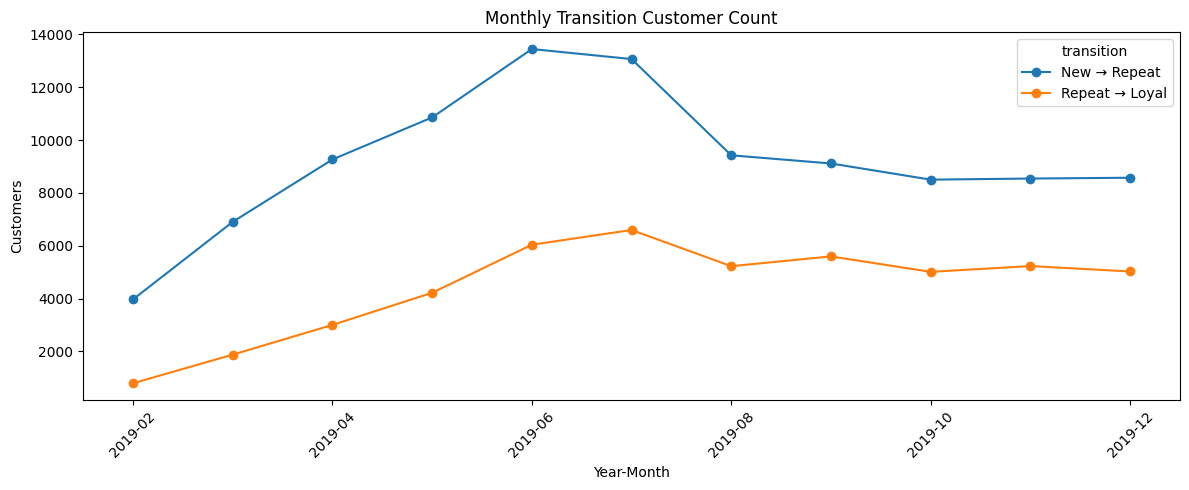

transition,New → Repeat,Repeat → Loyal
year_month,,
2019-02,3970,796
2019-03,6906,1880
2019-04,9266,3005
2019-05,10859,4221
2019-06,13446,6040
2019-07,13067,6597
2019-08,9424,5228
2019-09,9115,5597
2019-10,8503,5013


In [26]:
transition_monthly_pivot.plot(kind="line", marker="o", figsize=(12, 5))
plt.title("Monthly Transition Customer Count")
plt.xlabel("Year-Month")
plt.ylabel("Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
transition_monthly_pivot

#### New → Repeat
- 2월~6월까지 빠른 증가율 
    - 약 4천 → 약 1.3만 수준으로 증가
- 7월 이후 감소 및 정체
    - 6월 정점 이후 8월에 급락
    - 하반기에는 8.5천 내외로 안정화

#### Repeat → Loyal
- 2월~7월까지 꾸준한 증가
    - 약 800 → 약 6,500 수준으로 증가
- 8월 이후 완만한 하락/정체
    - 5천 초반에서 안정화된 상태

> New → Repeat 전환의 정점(6월) 이후 약 1개월 뒤, Repeat→Loyal 전환이 정점(7월)을 기록했습니다.<br>
이는 고객이 재구매 단계에 진입 이후, 충성 고객으로 전환되기까지 평균적으로 약 1개월의 시차가 존재하다는것을 알수 있습니다?

## 누적구매율 전환시점에서 확인하는 나이대별 차이

In [ ]:
# 고객 속성 테이블 구성 (고객 단위)

# 고객 나이대 정보만 추출
cust_attr = (
    analysis_cust[
        ["customer_id"
        , "age_group"
        , "FN"
        , "Active"
        , "club_member_status"]
    ]
    .drop_duplicates("customer_id")
    .copy()
)

# 전환 이벤트에 나이대 붙이기
# 고객 속성이 없을수도 있기 때문에 left
transition_events_age = (
    transition_events
    .merge(
    cust_attr
    , on="customer_id"
    , how="left"
))
transition_events_age.shape

(150312, 10)

In [ ]:
transition_age_month_cnt = (
    transition_events_age
    .groupby(
        ["year_month"
        , "age_group"
        , "transition"]
        , as_index=False)
    .agg(customer_cnt=("customer_id", "nunique"))
    .sort_values(["year_month", "age_group"])
)


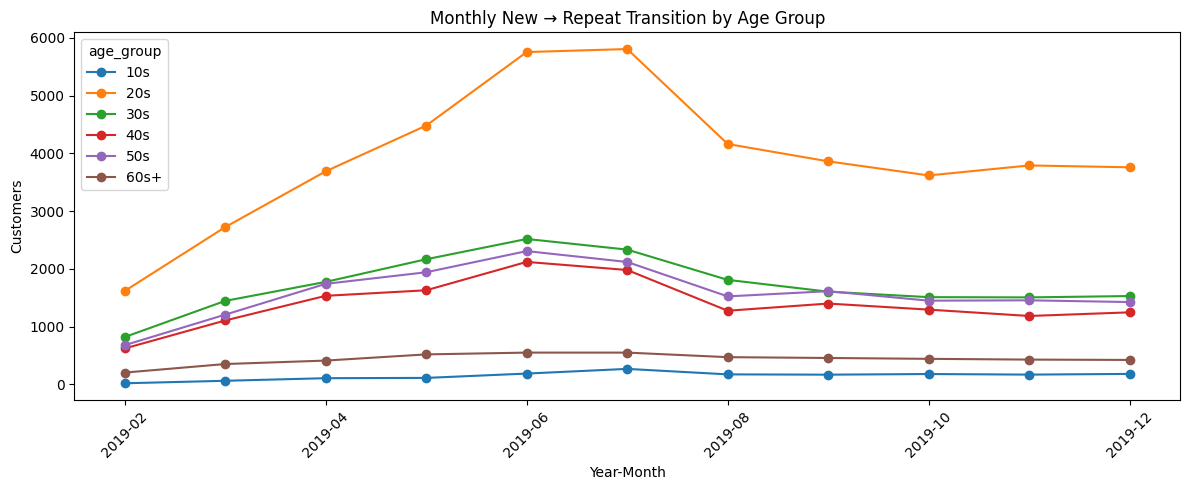

In [ ]:
# 최초 재구매 전환
nr_age = transition_age_month_cnt[
    transition_age_month_cnt["transition"] == "New → Repeat"
]

# 그래프용 피봇 테이블
nr_age_pivot = (
    nr_age
    .pivot(index="year_month", columns="age_group", values="customer_cnt")
    .fillna(0)
    .sort_index()
)

nr_age_pivot.plot(kind="line", marker="o", figsize=(12, 5))
plt.title("Monthly New → Repeat Transition by Age Group")
plt.xlabel("Year-Month")
plt.ylabel("Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

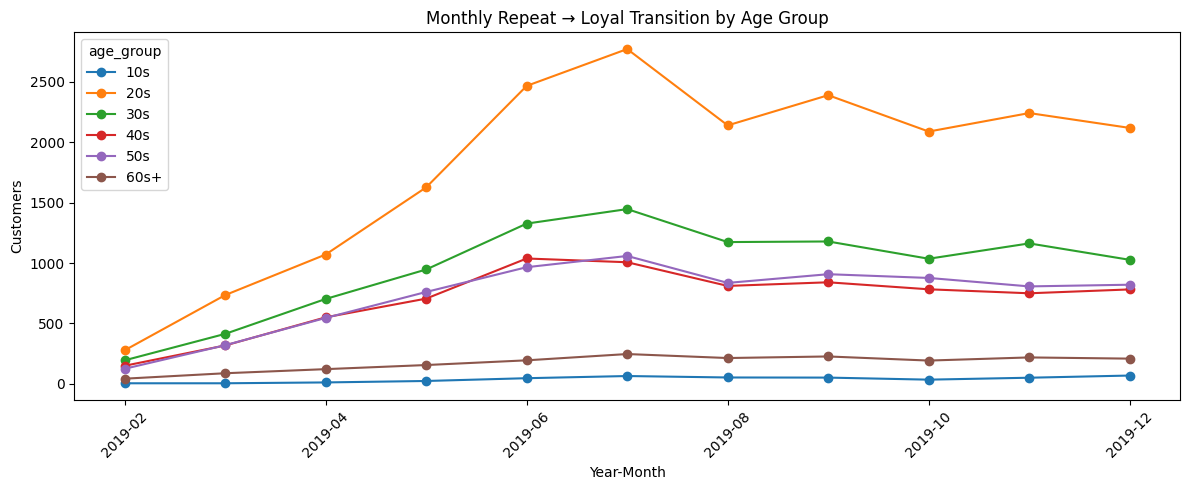

In [ ]:
# 최초 충성 전환
rl_age = transition_age_month_cnt[
    transition_age_month_cnt["transition"] == "Repeat → Loyal"
]

rl_age_pivot = (
    rl_age
    .pivot(index="year_month", columns="age_group", values="customer_cnt")
    .fillna(0)
    .sort_index()
)

rl_age_pivot.plot(kind="line", marker="o", figsize=(12, 5))
plt.title("Monthly Repeat → Loyal Transition by Age Group")
plt.xlabel("Year-Month")
plt.ylabel("Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

신규→재구매(New→Repeat) 전환 나이대 분석
- 전환 규모는 20대가 압도적으로 나타나고 있습니다.
    - 6~7월 피크: 약 5,700~5,800명
    - 30대는 그 다음(약 2,500명 수준)
    - 40·50대는 비슷한 중간 규모
    - 10대·60대는 매우 작음
> 신규 유입 → 첫 재구매는 ‘젊은 연령대’가 거의 전부를 만든다 판단 가능합니다.

특이사항
- 모든 연령대가 같은 타이밍에 움직인다
    - 모든 나이대가 2월→6~7월 증가
    - 8월에 동시에 하락 후 완만한 정체
> 특정 연령대만의 작용이 아닌 전체 시장/시즌 영향이라 추측 가능

재구매→충성(Repeat → Loyal) 전환 나이대 분석
- 20대가 여전히 가장 크지만 30대, 40대, 50대의 상대적 비중이 커지고 있다.
- New→Repeat보다 연령 분산이 훨씬 크게 측정된다.
> 충성층 전환은 반드시 젊은 층한테만 발생하는 것은 아니다.

특히 30대는, 유입은 적지만 충성으로 갈 확률이 높은 집단일 가능성이 크다

## 누적구매율과 비중으로 확인하는 고객 속성 분석

누적 관점에서 고객을
- 신규 고객
- 재구매 고객
- 충성 고객

으로 분류하고, <br>
각 그룹이 어떤 고객 속성(age_group, FN, 멤버십 등)을 가지는지를 비중 중심으로 분석한다.

## 전환 시점 고객 속성 분석

In [73]:
rev_attr = (
    total_revenue[["customer_id", "revenue_group"]]
    .drop_duplicates("customer_id")
    .copy()
)
rev_attr.shape

(455812, 2)

전체 연령용

```python
transition_attr = (
    transition_events
    .merge(cust_attr, on="customer_id", how="left")
    .merge(rev_attr, on="customer_id", how="left")
)
```

In [ ]:
# 전환 이벤트에 고객 속성 + 매출 속성 결합


transition_attr = (
    transition_events
    # 고객 속성 병합 (연령대, 멤버십, 활동 여부 등)
    .merge(cust_attr, on="customer_id", how="left")
    # 고객 매출/가치 속성 병합 (고객 등급, 누적 매출 등)
    .merge(rev_attr, on="customer_id", how="left")
)

# 20대 전환 고객만 추출
transition_attr_20s = transition_attr[
    transition_attr["age_group"] == "20s"
].copy()

# 30대 전환 고객만 추출
transition_attr_30s = transition_attr[
    transition_attr["age_group"] == "30s"
].copy()

transition_attr_20s.shape, transition_attr_30s.shape

((63203, 11), (29647, 11))

### 전환 시점 FN 상태

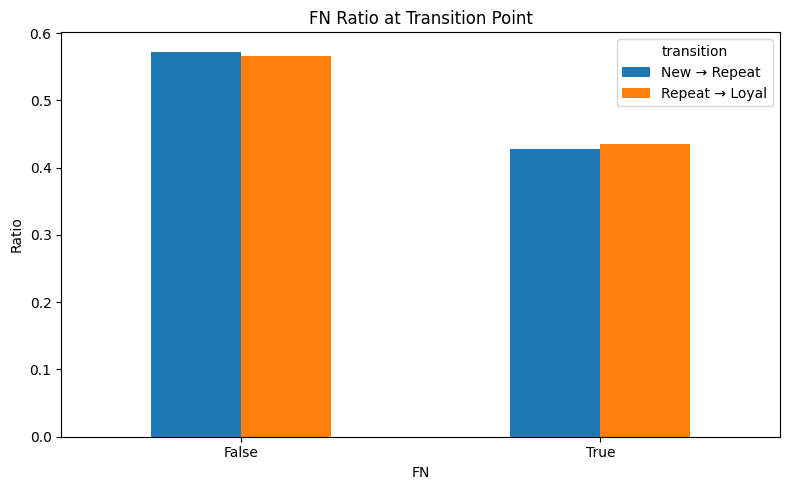

transition,New → Repeat,Repeat → Loyal
FN,,
False,0.572412,0.565429
True,0.427588,0.434571


In [ ]:
# 같은 전환유형 내에서
# FN구독고객 / 비구독 고객(20대)이 각각 몇 명인지 계산
# nunique 로 1고객 == 1행

fn_20s = (
    transition_attr_20s
    .groupby(["transition", "FN"], as_index=False)
    .agg(customer_cnt=("customer_id", "nunique"))
)

# 전환 비중 계산
fn_20s["ratio"] = (
    fn_20s["customer_cnt"]
    / fn_20s.groupby("transition")["customer_cnt"].transform("sum")
)

# 그래프용 피봇테이블
fn_pivot = (
    fn_20s
    .pivot(index="FN", columns="transition", values="ratio")
    .fillna(0)
)

fn_pivot.plot(kind="bar", figsize=(8, 5))
plt.title("FN Ratio at Transition Point")
plt.ylabel("Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

fn_pivot

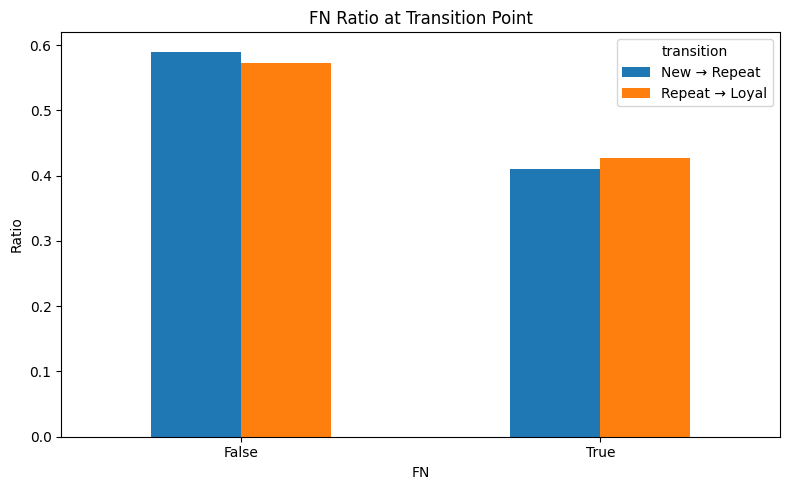

transition,New → Repeat,Repeat → Loyal
FN,,
False,0.590229,0.572559
True,0.409771,0.427441


In [ ]:
# 같은 전환유형 내에서
# FN구독고객 / 비구독 고객(30대)이 각각 몇 명인지 계산
# nunique 로 1고객 == 1행

fn_30s = (
    transition_attr_30s
    .groupby(["transition", "FN"], as_index=False)
    .agg(customer_cnt=("customer_id", "nunique"))
)

fn_30s["ratio"] = (
    fn_30s["customer_cnt"]
    / fn_30s.groupby("transition")["customer_cnt"].transform("sum")
)

# 그래프용 피봇테이블
fn_pivot = (
    fn_30s
    .pivot(index="FN", columns="transition", values="ratio")
    .fillna(0)
)

fn_pivot.plot(kind="bar", figsize=(8, 5))
plt.title("FN Ratio at Transition Point")
plt.ylabel("Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

fn_pivot

20대 분석
- New → Repeat: 약 42.8%
- Repeat → Loyal: 약 43.5%
> 전환 단계가 바뀌어도 FN 비중이 거의 변함 없음<br>
FN을 구독하든 안 하든 전환 확률 자체가 크게 달라지지 않는 구조로 파악된다.

30대 분석
- New → Repeat 단계: FN 비율 41.0%
- Repeat → Loyal 단계: FN 비율 42.7% (약간의 증가폭)
> FN이 초기 재구매 유도에는 큰 영향 없다로 파악 <br>
하지만 충성 고객으로 가는 단계에서는 약한 긍정 신호를 보인다.

20대 30대 모두 Fn의 여부가 전환 촉진 장치로써 작용하긴 어려운것으로 판단된다.

### 전환 시점 Active

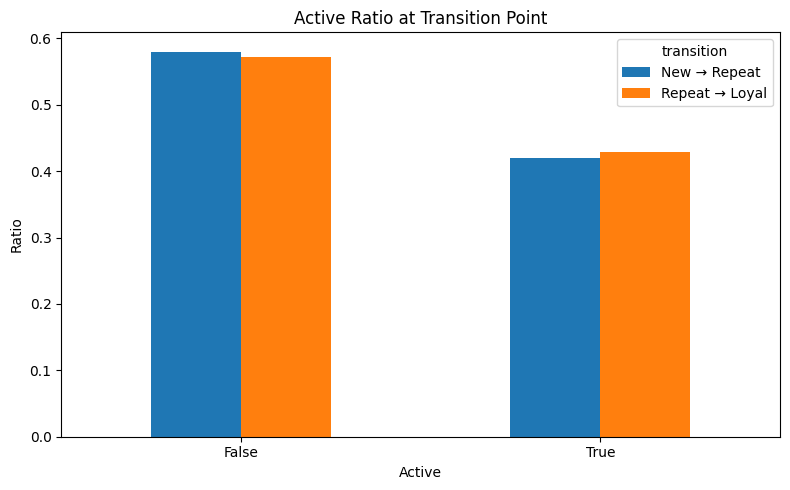

transition,New → Repeat,Repeat → Loyal
Active,,
False,0.580269,0.57145
True,0.419731,0.42855


In [ ]:
# 20대 활동 고객 여부
active_20s = (
    transition_attr_20s
    .groupby(["transition", "Active"], as_index=False)
    .agg(customer_cnt=("customer_id", "nunique"))
)

# 20대 활동 고객 여부 비율
active_20s["ratio"] = (
    active_20s["customer_cnt"]
    / active_20s.groupby("transition")["customer_cnt"].transform("sum")
)

# 그래프용 피봇
active_pivot = (
    active_20s
    .pivot(index="Active", columns="transition", values="ratio")
    .fillna(0)
)

active_pivot.plot(kind="bar", figsize=(8, 5))
plt.title("Active Ratio at Transition Point")
plt.ylabel("Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

active_pivot

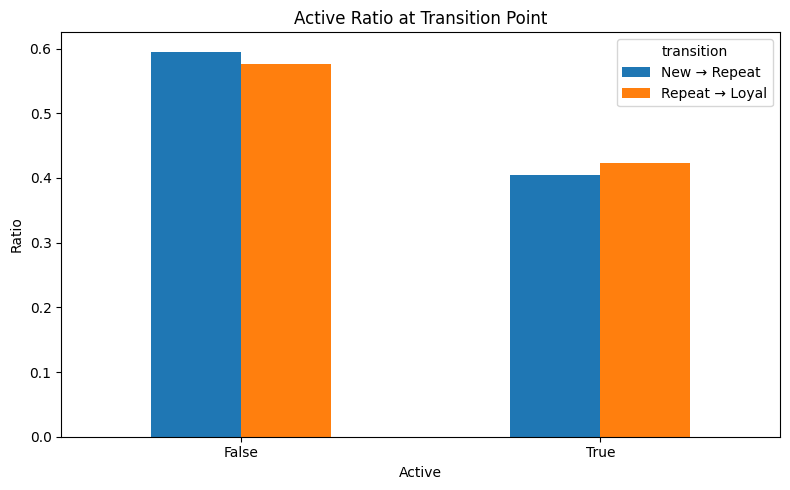

transition,New → Repeat,Repeat → Loyal
Active,,
False,0.595429,0.5768
True,0.404571,0.4232


In [ ]:
# 30대 활동 고객 여부
active_30s = (
    transition_attr_30s
    .groupby(["transition", "Active"], as_index=False)
    .agg(customer_cnt=("customer_id", "nunique"))
)

# 30대 활동 고객 여부 비중
active_30s["ratio"] = (
    active_30s["customer_cnt"]
    / active_30s.groupby("transition")["customer_cnt"].transform("sum")
)

# 그래프용 피봇
active_pivot = (
    active_20s
    .pivot(index="Active", columns="transition", values="ratio")
    .fillna(0)
)

active_pivot.plot(kind="bar", figsize=(8, 5))
plt.title("Active Ratio at Transition Point")
plt.ylabel("Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

active_pivot

20대~30대 활동 고객 여부와 전환율
- 두 전환 모두에서 Active = False가 다수
- Repeat → Loyal 단계에서 Active 비중이 소폭 증가 (41.97% → 42.86%)
> 전환 단계가 깊어질수록 활동 고객 비중이 커짐 이는 30대 일수록 경향이 강해진다.

> 재구매를 시작하게 만드는 조건보다 충성 고객으로 굳어지는 과정에서 중요해지는 상태 변수로 파악된다.

### 전환 시점 맴버십

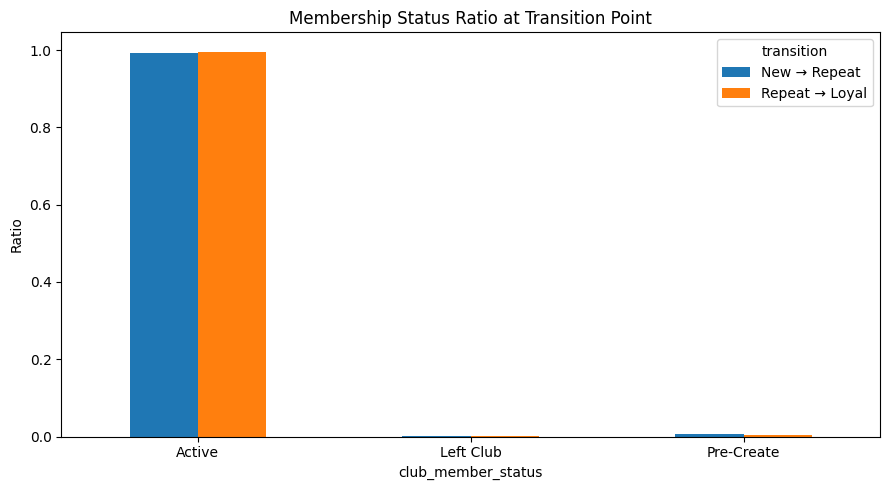

transition,New → Repeat,Repeat → Loyal
club_member_status,,
Active,0.992859,0.996086
Left Club,0.000324,0.000452
Pre-Create,0.006817,0.003462


In [ ]:
# 20 전환 시점 맴버십
member_20s = (
    transition_attr_20s
    .groupby(["transition", "club_member_status"], as_index=False)
    .agg(customer_cnt=("customer_id", "nunique"))
)

# 20 전환 시점 맴버십 비중
member_20s["ratio"] = (
    member_20s["customer_cnt"]
    / member_20s.groupby("transition")["customer_cnt"].transform("sum")
)

# 그래프용 피봇
member_pivot = (
    member_20s
    .pivot(index="club_member_status", columns="transition", values="ratio")
    .fillna(0)
)

member_pivot.plot(kind="bar", figsize=(9, 5))
plt.title("Membership Status Ratio at Transition Point")
plt.ylabel("Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

member_pivot

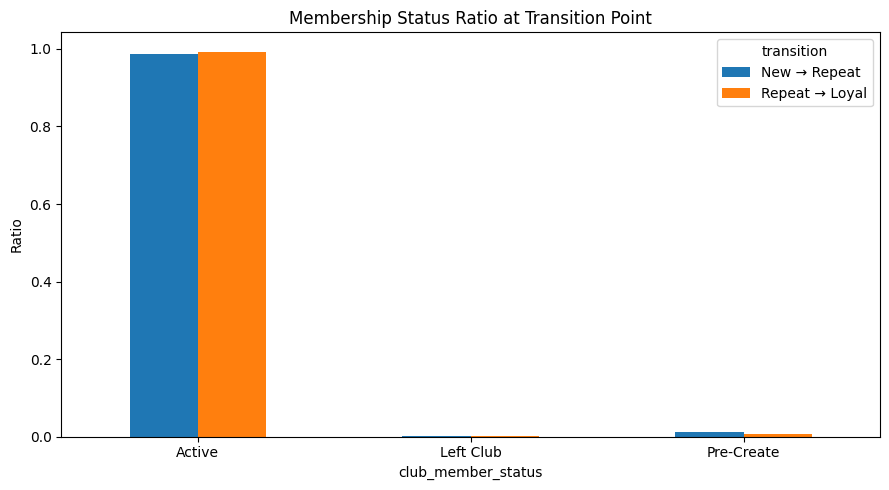

transition,New → Repeat,Repeat → Loyal
club_member_status,,
Active,0.987182,0.993215
Left Club,0.000473,0.000565
Pre-Create,0.012346,0.006219


In [ ]:
# 30 전환 시점 맴버십
member_30s = (
    transition_attr_30s
    .groupby(["transition", "club_member_status"], as_index=False)
    .agg(customer_cnt=("customer_id", "nunique"))
)

# 30 전환 시점 맴버십 비중
member_30s["ratio"] = (
    member_30s["customer_cnt"]
    / member_30s.groupby("transition")["customer_cnt"].transform("sum")
)

# 그래프용 피봇
member_pivot = (
    member_30s
    .pivot(index="club_member_status", columns="transition", values="ratio")
    .fillna(0)
)

member_pivot.plot(kind="bar", figsize=(9, 5))
plt.title("Membership Status Ratio at Transition Point")
plt.ylabel("Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

member_pivot

- 20~30대 분석
    - 전환(New → Repeat, Repeat → Loyal)은 사실상 "클럽 Active 회원" 안에서만 발생
    - 멤버십 상태는 "전환에 영향을 주는 변수"가 아니라 전환이 발생하기 위한 전제 조건?

### 전환시점 상위 하위 20% (큰 의미는 없어보임)

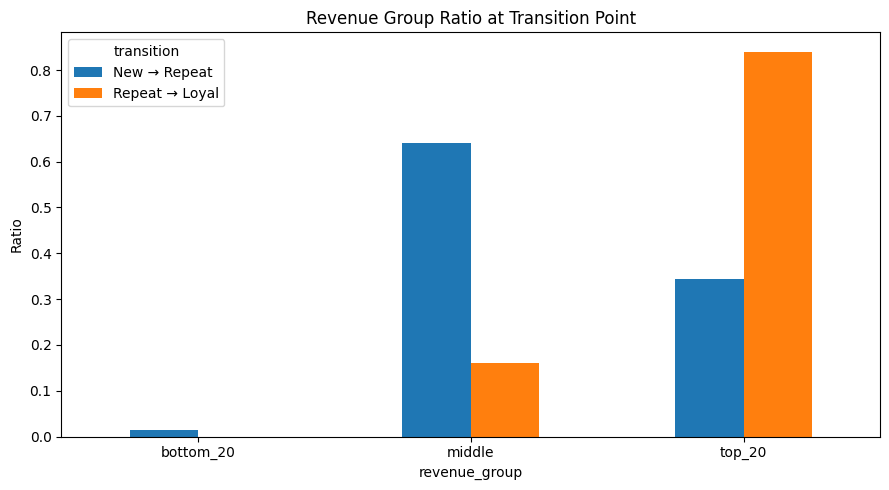

transition,New → Repeat,Repeat → Loyal
revenue_group,,
bottom_20,0.014050,0.000100
middle,0.640977,0.159609
top_20,0.344973,0.840291


In [42]:
revenue_20s = (
    transition_attr_20s
    .groupby(["transition", "revenue_group"], as_index=False)
    .agg(customer_cnt=("customer_id", "nunique"))
)

revenue_20s["ratio"] = (
    revenue_20s["customer_cnt"]
    / revenue_20s.groupby("transition")["customer_cnt"].transform("sum")
)

revenue_pivot = (
    revenue_20s
    .pivot(index="revenue_group", columns="transition", values="ratio")
    .fillna(0)
)

revenue_pivot.plot(kind="bar", figsize=(9, 5))
plt.title("Revenue Group Ratio at Transition Point")
plt.ylabel("Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

revenue_pivot

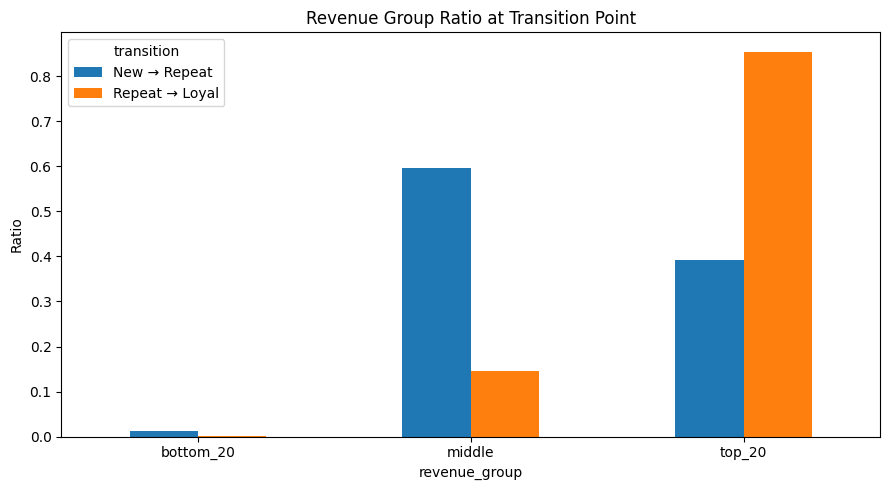

transition,New → Repeat,Repeat → Loyal
revenue_group,,
bottom_20,0.012030,0.000188
middle,0.596323,0.144930
top_20,0.391647,0.854881


In [43]:
revenue_30s = (
    transition_attr_30s
    .groupby(["transition", "revenue_group"], as_index=False)
    .agg(customer_cnt=("customer_id", "nunique"))
)

revenue_30s["ratio"] = (
    revenue_30s["customer_cnt"]
    / revenue_30s.groupby("transition")["customer_cnt"].transform("sum")
)

revenue_pivot = (
    revenue_30s
    .pivot(index="revenue_group", columns="transition", values="ratio")
    .fillna(0)
)

revenue_pivot.plot(kind="bar", figsize=(9, 5))
plt.title("Revenue Group Ratio at Transition Point")
plt.ylabel("Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

revenue_pivot

## 상품군별 분석

### 전환 시점 구매데이터

```python
# 전환 시점의 거래만 추출
transition_tx_art = (
    total_revenue
    .merge(
        transition_events,
        on=["customer_id", "year_month"],
        how="inner"
    )
    .merge(
        art,
        on="article_id",
        how="left"
    )
)
```
전체나이용

In [44]:
# 전환 시점의 거래만 추출
transition_tx_art = (
    total_revenue
    .merge(
        transition_events,
        on=["customer_id", "year_month"],
        how="inner"
    )
    .merge(
        art,
        on="article_id",
        how="left"
    )
)

transition_tx_art_age = transition_tx_art.merge(
    cust[["customer_id", "age_group"]],
    on="customer_id",
    how="left"
)

transition_tx_art_20s = transition_tx_art_age[
    transition_tx_art_age["age_group"] == "20s"
].copy()

transition_tx_art_30s = transition_tx_art_age[
    transition_tx_art_age["age_group"] == "30s"
].copy()


### 전환시점 상품군 분석 (의류 대분류)
- product_group_name

In [45]:
pg_20 = (
    transition_tx_art_20s
    .groupby(["transition", "product_group_name"], as_index=False)
    .agg(purchase_cnt=("article_id", "count"))
)

pg_20["ratio"] = (
    pg_20["purchase_cnt"]
    / pg_20.groupby("transition")["purchase_cnt"].transform("sum")
)

top7_pg = (
    pg_20
    .groupby("product_group_name")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(7)
    .index
)

pg_top7 = pg_20[
    pg_20["product_group_name"].isin(top7_pg)
].copy()


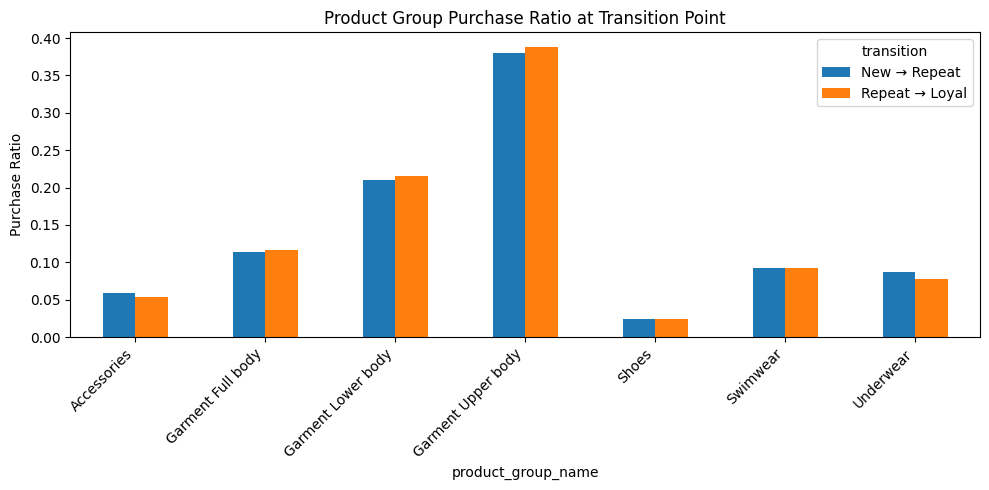

transition,New → Repeat,Repeat → Loyal
product_group_name,,
Accessories,0.059621,0.053560
Garment Full body,0.113195,0.116945
Garment Lower body,0.209864,0.215918
Garment Upper body,0.379508,0.388276
Shoes,0.023714,0.024677
Swimwear,0.092966,0.092091
Underwear,0.086762,0.078326


In [46]:
pg_pivot = (
    pg_top7
    .pivot(
        index="product_group_name",
        columns="transition",
        values="ratio"
    )
    .fillna(0)
)

pg_pivot.plot(kind="bar", figsize=(10, 5))
plt.title("Product Group Purchase Ratio at Transition Point")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
pg_pivot

In [47]:
pg_30 = (
    transition_tx_art_30s
    .groupby(["transition", "product_group_name"], as_index=False)
    .agg(purchase_cnt=("article_id", "count"))
)

pg_30["ratio"] = (
    pg_30["purchase_cnt"]
    / pg_30.groupby("transition")["purchase_cnt"].transform("sum")
)

top7_pg = (
    pg_30
    .groupby("product_group_name")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(7)
    .index
)

pg_top7 = pg_30[
    pg_30["product_group_name"].isin(top7_pg)
].copy()


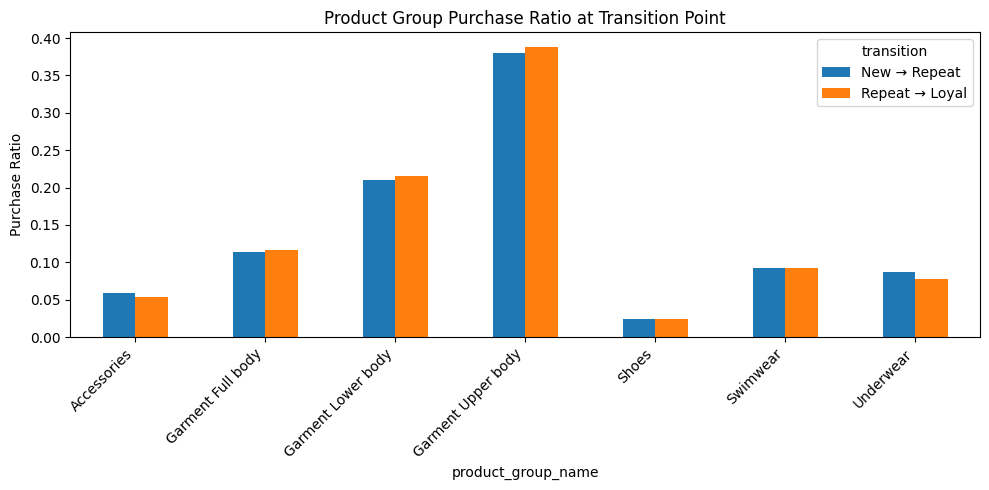

transition,New → Repeat,Repeat → Loyal
product_group_name,,
Accessories,0.059621,0.053560
Garment Full body,0.113195,0.116945
Garment Lower body,0.209864,0.215918
Garment Upper body,0.379508,0.388276
Shoes,0.023714,0.024677
Swimwear,0.092966,0.092091
Underwear,0.086762,0.078326


In [48]:
pg_30 = (
    pg_top7
    .pivot(
        index="product_group_name",
        columns="transition",
        values="ratio"
    )
    .fillna(0)
)

pg_pivot.plot(kind="bar", figsize=(10, 5))
plt.title("Product Group Purchase Ratio at Transition Point")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
pg_pivot

### 상품군 분석 2 (중뷴류: 제품 타입)
- product_type_info

In [49]:
pt_20s = (
    transition_tx_art_20s
    .groupby(["transition", "product_type_info"], as_index=False)
    .agg(purchase_cnt=("article_id", "count"))
)

pt_20s["ratio"] = (
    pt_20s["purchase_cnt"]
    / pt_20s.groupby("transition")["purchase_cnt"].transform("sum")
)

top7_pt = (
    pt_20s
    .groupby("product_type_info")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(7)
    .index
)

pt_top7 = pt_20s[
    pt_20s["product_type_info"].isin(top7_pt)
].copy()

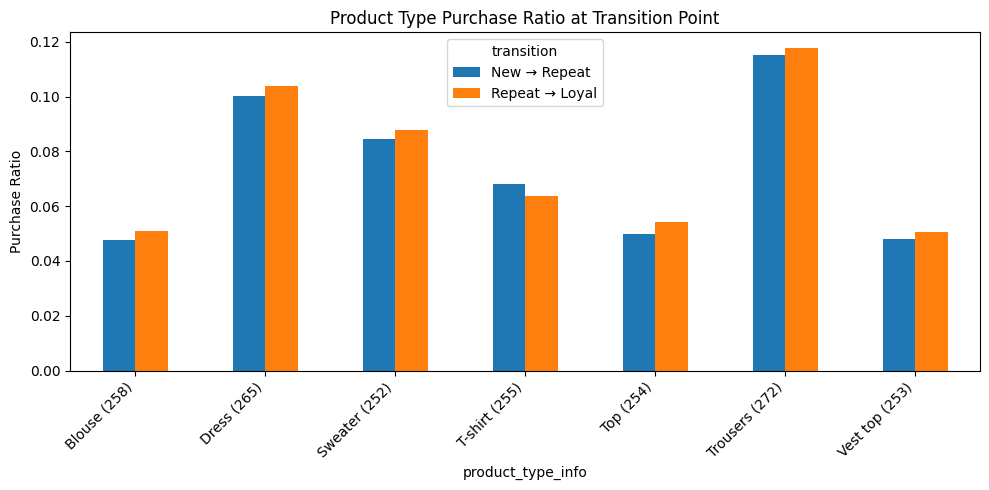

transition,New → Repeat,Repeat → Loyal
product_type_info,,
Blouse (258),0.047547,0.050943
Dress (265),0.100392,0.103885
Sweater (252),0.084438,0.087885
T-shirt (255),0.068228,0.063620
Top (254),0.049910,0.054060
Trousers (272),0.115263,0.117592
Vest top (253),0.047921,0.050501


In [50]:
pt_pivot = (
    pt_top7
    .pivot(
        index="product_type_info",
        columns="transition",
        values="ratio"
    )
    .fillna(0)
)

pt_pivot.plot(kind="bar", figsize=(10, 5))
plt.title("Product Type Purchase Ratio at Transition Point")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

pt_pivot

In [51]:
pt_30s = (
    transition_tx_art_30s
    .groupby(["transition", "product_type_info"], as_index=False)
    .agg(purchase_cnt=("article_id", "count"))
)

pt_30s["ratio"] = (
    pt_30s["purchase_cnt"]
    / pt_30s.groupby("transition")["purchase_cnt"].transform("sum")
)

top7_pt = (
    pt_30s
    .groupby("product_type_info")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(7)
    .index
)

pt_top7 = pt_30s[
    pt_30s["product_type_info"].isin(top7_pt)
].copy()

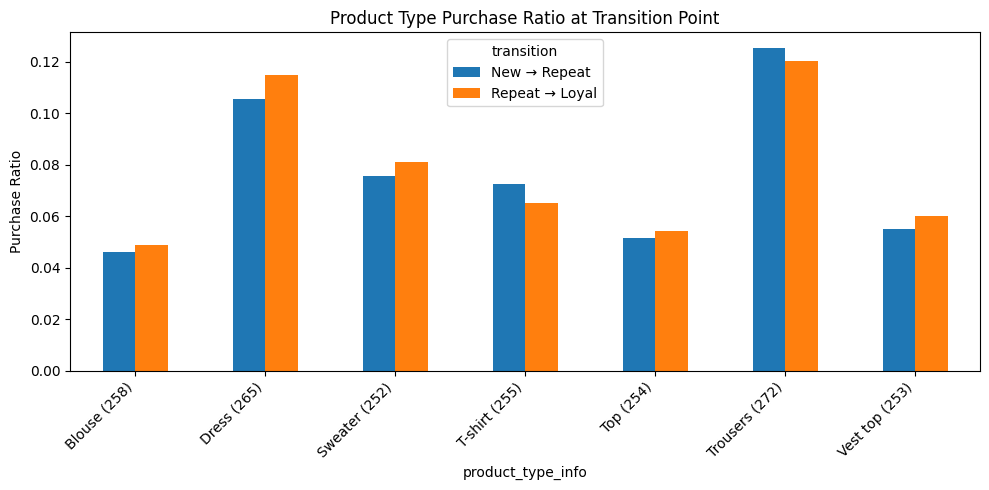

transition,New → Repeat,Repeat → Loyal
product_type_info,,
Blouse (258),0.045949,0.048717
Dress (265),0.105497,0.114734
Sweater (252),0.075701,0.080836
T-shirt (255),0.072576,0.064885
Top (254),0.051450,0.054214
Trousers (272),0.125127,0.120285
Vest top (253),0.054883,0.060034


In [52]:
pt_pivot = (
    pt_top7
    .pivot(
        index="product_type_info",
        columns="transition",
        values="ratio"
    )
    .fillna(0)
)

pt_pivot.plot(kind="bar", figsize=(10, 5))
plt.title("Product Type Purchase Ratio at Transition Point")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

pt_pivot

### 상품군 분석 3 (의류 형태)
- garment_group_info

In [53]:
gg_20s = (
    transition_tx_art_20s
    .groupby(["transition", "garment_group_info"], as_index=False)
    .agg(purchase_cnt=("article_id", "count"))
)

gg_20s["ratio"] = (
    gg_20s["purchase_cnt"]
    / gg_20s.groupby("transition")["purchase_cnt"].transform("sum")
)

top5_gg = (
    gg_20s
    .groupby("garment_group_info")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

gg_top5 = gg_20s[
    gg_20s["garment_group_info"].isin(top5_gg)
].copy()


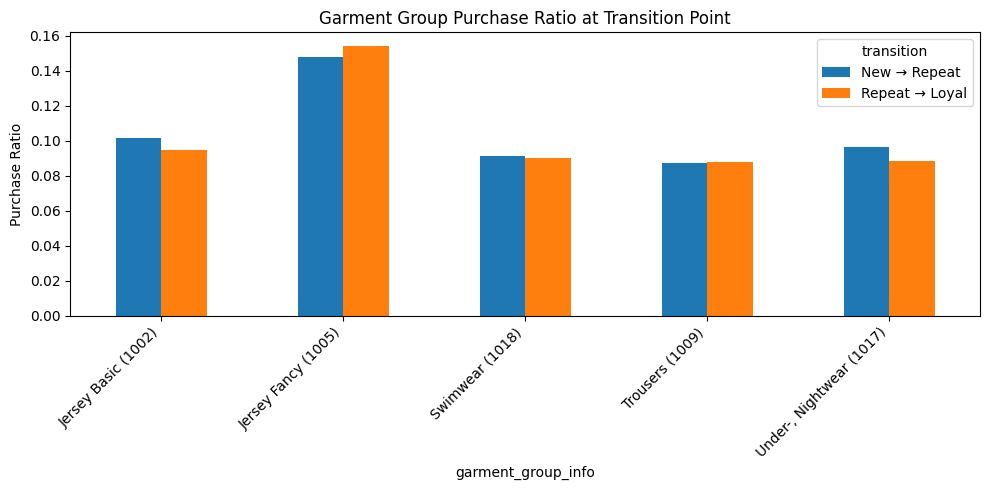

transition,New → Repeat,Repeat → Loyal
garment_group_info,,
Jersey Basic (1002),0.101554,0.094915
Jersey Fancy (1005),0.147821,0.154328
Swimwear (1018),0.091548,0.090061
Trousers (1009),0.087195,0.087856
"Under-, Nightwear (1017)",0.096571,0.088650


In [54]:
gg_pivot = (
    gg_top5
    .pivot(
        index="garment_group_info",
        columns="transition",
        values="ratio"
    )
    .fillna(0)
)

gg_pivot.plot(kind="bar", figsize=(10, 5))
plt.title("Garment Group Purchase Ratio at Transition Point")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

gg_pivot

In [55]:
gg_30s = (
    transition_tx_art_30s
    .groupby(["transition", "garment_group_info"], as_index=False)
    .agg(purchase_cnt=("article_id", "count"))
)

gg_30s["ratio"] = (
    gg_30s["purchase_cnt"]
    / gg_30s.groupby("transition")["purchase_cnt"].transform("sum")
)

top5_gg = (
    gg_30s
    .groupby("garment_group_info")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

gg_top5 = gg_30s[
    gg_30s["garment_group_info"].isin(top5_gg)
].copy()


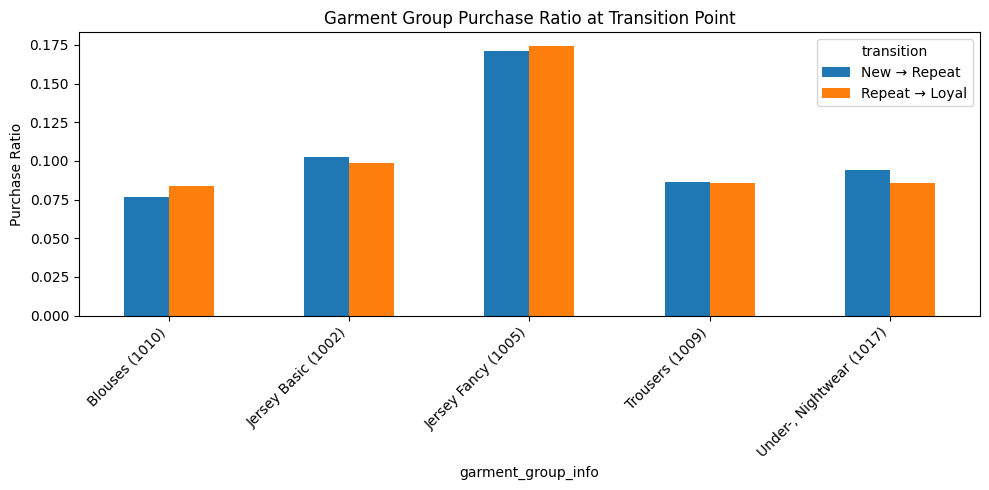

transition,New → Repeat,Repeat → Loyal
garment_group_info,,
Blouses (1010),0.076405,0.083800
Jersey Basic (1002),0.102768,0.098836
Jersey Fancy (1005),0.171383,0.174445
Trousers (1009),0.086484,0.086064
"Under-, Nightwear (1017)",0.093922,0.085740


In [56]:
gg_pivot = (
    gg_top5
    .pivot(
        index="garment_group_info",
        columns="transition",
        values="ratio"
    )
    .fillna(0)
)

gg_pivot.plot(kind="bar", figsize=(10, 5))
plt.title("Garment Group Purchase Ratio at Transition Point")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

gg_pivot

### 상품군 분석 4 (타겟 고객군)
- section_info

In [57]:
section_20s = (
    transition_tx_art_20s
    .groupby(["transition", "section_info"], as_index=False)
    .agg(purchase_cnt=("article_id", "count"))
)

# 전환 유형별 구매 비중
section_20s["ratio"] = (
    section_20s["purchase_cnt"]
    / section_20s.groupby("transition")["purchase_cnt"].transform("sum")
)

# 전체 전환 기준 상위 section 선정 (Top 7)
top7_section = (
    section_20s
    .groupby("section_info")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(7)
    .index
)

section_top7 = section_20s[
    section_20s["section_info"].isin(top7_section)
].copy()

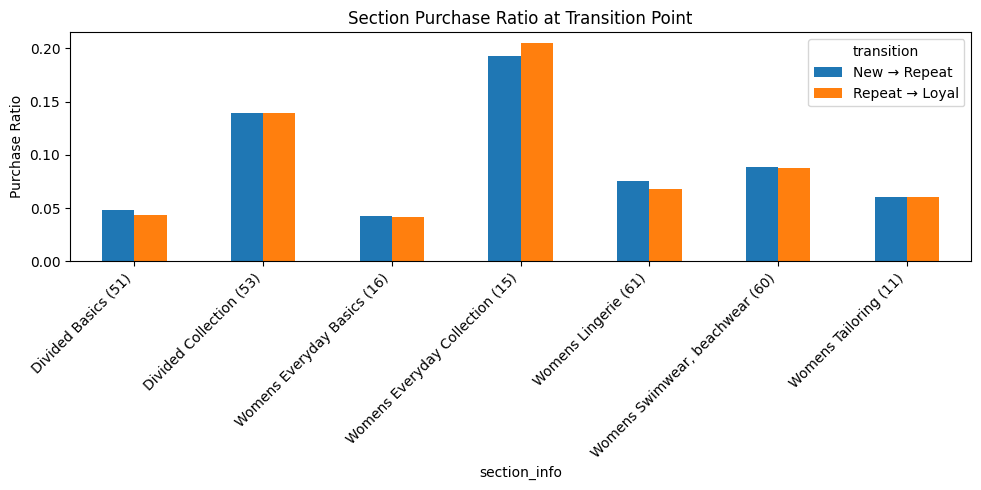

transition,New → Repeat,Repeat → Loyal
section_info,,
Divided Basics (51),0.048217,0.043295
Divided Collection (53),0.139154,0.139386
Womens Everyday Basics (16),0.042170,0.042001
Womens Everyday Collection (15),0.192551,0.204830
Womens Lingerie (61),0.075259,0.067973
"Womens Swimwear, beachwear (60)",0.088889,0.087591
Womens Tailoring (11),0.060152,0.060266


In [58]:
section_pivot = (
    section_top7
    .pivot(
        index="section_info",
        columns="transition",
        values="ratio"
    )
    .fillna(0)
)

# 시각화
section_pivot.plot(kind="bar", figsize=(10, 5))
plt.title("Section Purchase Ratio at Transition Point")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

section_pivot

In [59]:
section_30s = (
    transition_tx_art_30s
    .groupby(["transition", "section_info"], as_index=False)
    .agg(purchase_cnt=("article_id", "count"))
)

section_30s["ratio"] = (
    section_30s["purchase_cnt"]
    / section_30s.groupby("transition")["purchase_cnt"].transform("sum")
)

# 전체 전환 기준 상위 section 선정 (Top 7)
top7_section = (
    section_30s
    .groupby("section_info")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(7)
    .index
)

section_top7 = section_30s[
    section_30s["section_info"].isin(top7_section)
].copy()

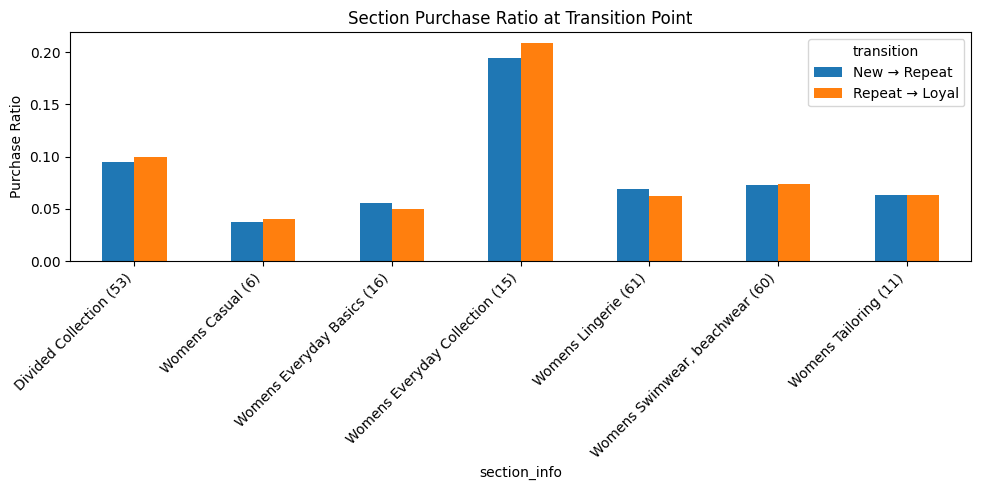

transition,New → Repeat,Repeat → Loyal
section_info,,
Divided Collection (53),0.094714,0.099375
Womens Casual (6),0.037894,0.040310
Womens Everyday Basics (16),0.055455,0.049580
Womens Everyday Collection (15),0.194006,0.208396
Womens Lingerie (61),0.069495,0.062837
"Womens Swimwear, beachwear (60)",0.072928,0.073884
Womens Tailoring (11),0.063333,0.063484


In [60]:
section_pivot = (
    section_top7
    .pivot(
        index="section_info",
        columns="transition",
        values="ratio"
    )
    .fillna(0)
)

# 시각화
section_pivot.plot(kind="bar", figsize=(10, 5))
plt.title("Section Purchase Ratio at Transition Point")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

section_pivot

### 상품군 분석 5 (패턴/무늬)
- graphical_appearance_info

In [61]:
# 전환 시점 x 패턴(graphical_appearance_info) 구매 집계
pattern_20s = (
    transition_tx_art_20s
    .groupby(["transition", "graphical_appearance_info"], as_index=False)
    .agg(purchase_cnt=("article_id", "count"))
)

# 전환 유형별 구매 비중
pattern_20s["ratio"] = (
    pattern_20s["purchase_cnt"]
    / pattern_20s.groupby("transition")["purchase_cnt"].transform("sum")
)

# 전체 전환 기준 상위 패턴 선정 (Top 7)
top7_pattern = (
    pattern_20s
    .groupby("graphical_appearance_info")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(7)
    .index
)

pattern_top7 = pattern_20s[
    pattern_20s["graphical_appearance_info"].isin(top7_pattern)
].copy()

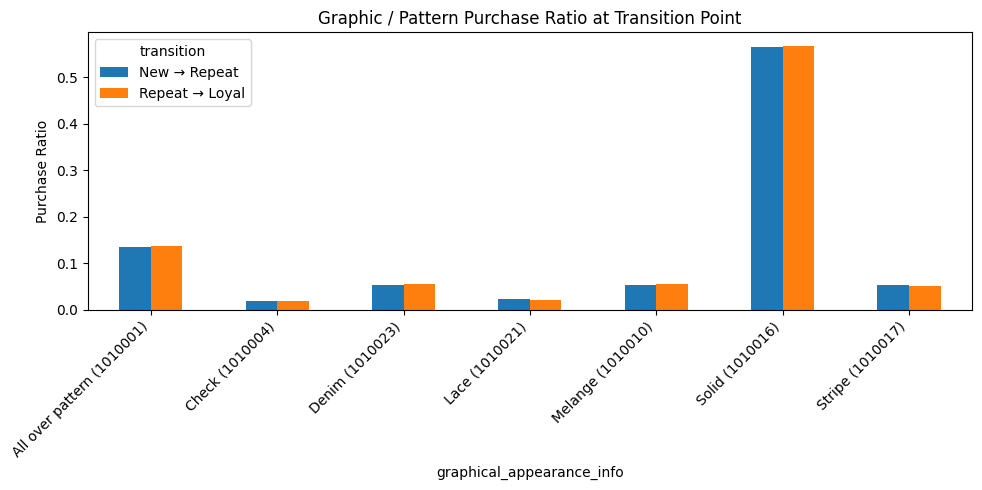

transition,New → Repeat,Repeat → Loyal
graphical_appearance_info,,
All over pattern (1010001),0.135786,0.136975
Check (1010004),0.019460,0.018824
Denim (1010023),0.054184,0.054531
Lace (1010021),0.022375,0.021383
Melange (1010010),0.052628,0.054766
Solid (1010016),0.564633,0.567840
Stripe (1010017),0.052550,0.050501


In [62]:
# 그래프용 pivot
pattern_pivot = (
    pattern_top7
    .pivot(
        index="graphical_appearance_info",
        columns="transition",
        values="ratio"
    )
    .fillna(0)
)

# 시각화
pattern_pivot.plot(kind="bar", figsize=(10, 5))
plt.title("Graphic / Pattern Purchase Ratio at Transition Point")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

pattern_pivot

In [63]:
# 전환 시점 x 패턴(graphical_appearance_info) 구매 집계
pattern_30s = (
    transition_tx_art_30s
    .groupby(["transition", "graphical_appearance_info"], as_index=False)
    .agg(purchase_cnt=("article_id", "count"))
)

# 전환 유형별 구매 비중
pattern_30s["ratio"] = (
    pattern_30s["purchase_cnt"]
    / pattern_30s.groupby("transition")["purchase_cnt"].transform("sum")
)

# 전체 전환 기준 상위 패턴 선정 (Top 7)
top7_pattern = (
    pattern_30s
    .groupby("graphical_appearance_info")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(7)
    .index
)

pattern_top7 = pattern_30s[
    pattern_30s["graphical_appearance_info"].isin(top7_pattern)
].copy()

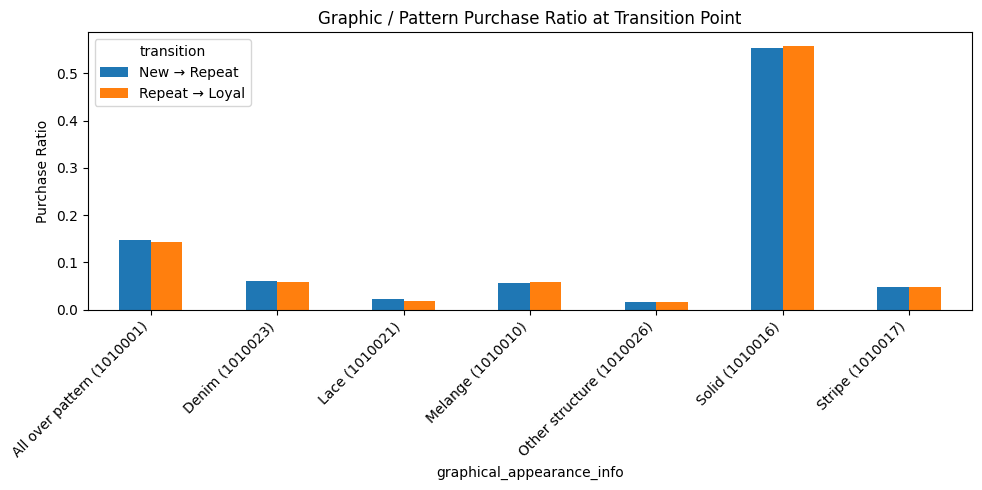

transition,New → Repeat,Repeat → Loyal
graphical_appearance_info,,
All over pattern (1010001),0.148145,0.143781
Denim (1010023),0.060165,0.059496
Lace (1010021),0.022754,0.019455
Melange (1010010),0.057172,0.058849
Other structure (1010026),0.017077,0.016491
Solid (1010016),0.553981,0.558741
Stripe (1010017),0.049162,0.049095


In [64]:
# 그래프용 pivot
pattern_pivot = (
    pattern_top7
    .pivot(
        index="graphical_appearance_info",
        columns="transition",
        values="ratio"
    )
    .fillna(0)
)

# 시각화
pattern_pivot.plot(kind="bar", figsize=(10, 5))
plt.title("Graphic / Pattern Purchase Ratio at Transition Point")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

pattern_pivot

### 상품군 분석 6 (색상 계열)
- perceived_colour_master_info

In [65]:
# 전환 시점 × 색상(perceived_colour_master_info) 구매 집계
color_20s = (
    transition_tx_art
    .groupby(["transition", "perceived_colour_master_info"], as_index=False)
    .agg(purchase_cnt=("article_id", "count"))
)

# 전환 유형별 구매 비중
color_20s["ratio"] = (
    color_20s["purchase_cnt"]
    / color_20s.groupby("transition")["purchase_cnt"].transform("sum")
)

# 전체 전환 기준 상위 색상 선정 (Top 7)
top7_color = (
    color_20s
    .groupby("perceived_colour_master_info")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(7)
    .index
)

color_top7 = color_20s[
    color_20s["perceived_colour_master_info"].isin(top7_color)
].copy()

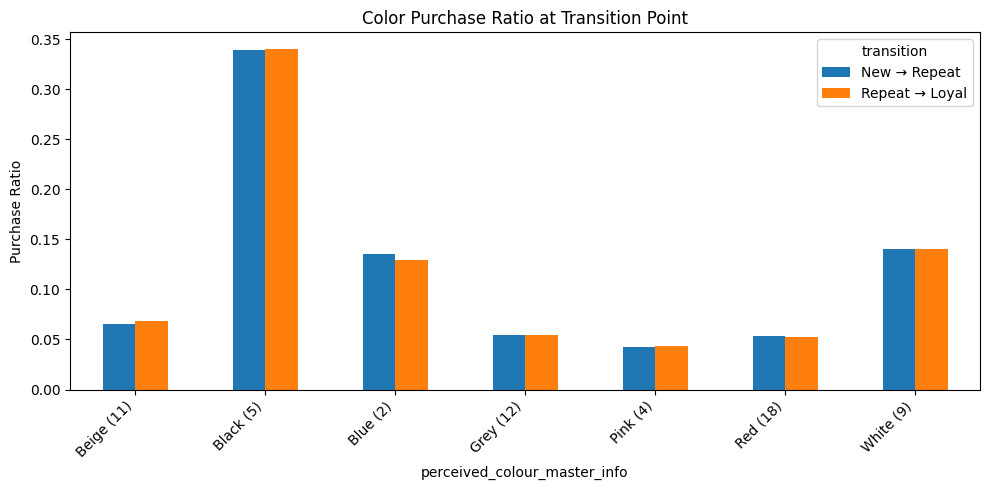

transition,New → Repeat,Repeat → Loyal
perceived_colour_master_info,,
Beige (11),0.065250,0.068562
Black (5),0.338872,0.339991
Blue (2),0.135254,0.129266
Grey (12),0.054351,0.054182
Pink (4),0.042783,0.043454
Red (18),0.053899,0.052675
White (9),0.140804,0.140247


In [66]:
# 그래프용 pivot
color_pivot = (
    color_top7
    .pivot(
        index="perceived_colour_master_info",
        columns="transition",
        values="ratio"
    )
    .fillna(0)
)

# 시각화
color_pivot.plot(kind="bar", figsize=(10, 5))
plt.title("Color Purchase Ratio at Transition Point")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

color_pivot

In [67]:
color_30s = (
    transition_tx_art_30s
    .groupby(["transition", "perceived_colour_master_info"], as_index=False)
    .agg(purchase_cnt=("article_id", "count"))
)

# 전환 유형별 구매 비중
color_30s["ratio"] = (
    color_30s["purchase_cnt"]
    / color_30s.groupby("transition")["purchase_cnt"].transform("sum")
)

# 전체 전환 기준 상위 색상 선정 (Top 7)
top7_color = (
    color_30s
    .groupby("perceived_colour_master_info")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(7)
    .index
)

color_top7 = color_30s[
    color_30s["perceived_colour_master_info"].isin(top7_color)
].copy()

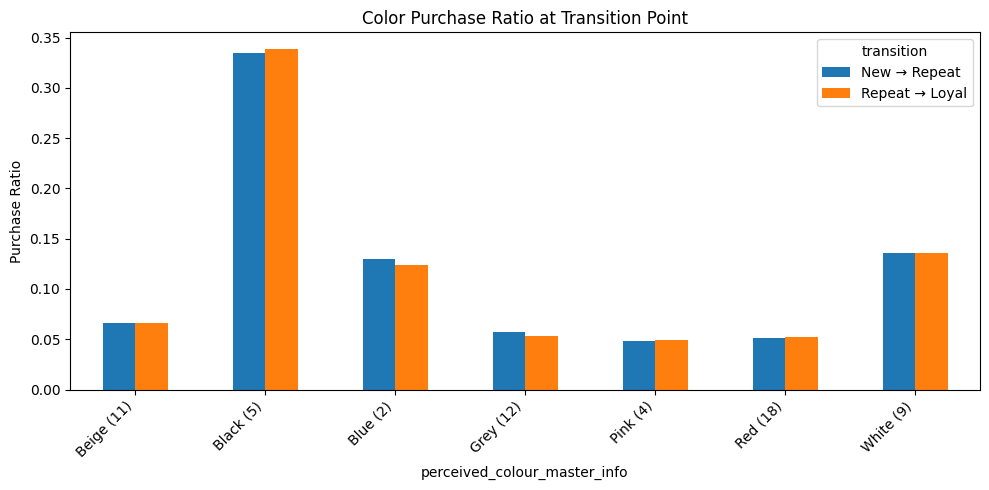

transition,New → Repeat,Repeat → Loyal
perceived_colour_master_info,,
Beige (11),0.066590,0.066286
Black (5),0.335108,0.338381
Blue (2),0.130100,0.123572
Grey (12),0.056996,0.053352
Pink (4),0.048237,0.049149
Red (18),0.051362,0.052436
White (9),0.135381,0.135374


In [68]:
# 그래프용 pivot
color_pivot = (
    color_top7
    .pivot(
        index="perceived_colour_master_info",
        columns="transition",
        values="ratio"
    )
    .fillna(0)
)

# 시각화
color_pivot.plot(kind="bar", figsize=(10, 5))
plt.title("Color Purchase Ratio at Transition Point")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

color_pivot